# Crypto Predictions based on Indicators with XGBoost

This notebook is using tradeview.com data with various indicators to determine which indicators are the strongest.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from pathlib import Path
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

/Users/rachelbates/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(250,250,250,0.8)'
)

fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [4]:
# Import the data into a Pandas Dataframe
btc_df = pd.read_csv(
    Path('csv_files/AVAX/AVAXUSD_1_day.csv'), 
    infer_datetime_format=True, 
    parse_dates=True
)


btc_df['time'] = pd.to_datetime(btc_df['time'])
btc_df.index = range(len(btc_df))
img_name = 'avax_1d_'

# Review the DataFrame
btc_df

,time,open,high,low,close,Plot,Up Trend,Down Trend,VWAP,Upper Band,...,Lower Bollinger Band,Histogram,MACD,Signal,CCI,Smoothing Line.1,ADX,+DI,-DI,CHOP
0,2020-07-13 00:00:00+00:00,4.632393,4.967011,4.458297,4.895398,4.763895,NaN,0.000000,4.773569,4.773569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-07-14 00:00:00+00:00,4.895414,10.455933,4.819692,10.297383,7.596399,NaN,NaN,8.524336,8.524336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-07-15 00:00:00+00:00,10.299174,10.520292,10.118034,10.392932,10.346053,NaN,NaN,10.343753,10.343753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-07-16 00:00:00+00:00,10.393384,10.552311,10.050180,10.358947,10.376165,NaN,NaN,10.320479,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-07-17 00:00:00+00:00,10.358950,10.523359,10.125700,10.363876,10.361413,NaN,NaN,10.337645,10.337645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,2022-04-12 00:00:00+00:00,74.355212,79.505917,73.943950,76.338093,75.346653,NaN,97.192745,76.595987,76.595987,...,NaN,-2.425732,-1.073765,1.351967,-143.724422,-112.065327,21.069699,14.599291,23.586854,45.486205
639,2022-04-13 00:00:00+00:00,76.353576,80.657756,75.808767,80.184762,78.269169,NaN,97.192745,78.883762,78.883762,...,NaN,-2.127238,-1.307081,0.820158,-106.161498,-120.027748,20.959530,15.067637,22.380201,43.167975
640,2022-04-14 00:00:00+00:00,80.190765,81.858316,76.181551,76.827128,78.508946,NaN,97.192745,78.288998,78.288998,...,NaN,-2.050388,-1.742828,0.307561,-104.316392,-123.786754,20.557173,15.436087,21.024183,42.139473
641,2022-04-15 00:00:00+00:00,76.838253,78.515322,74.770363,77.469503,77.153878,NaN,95.398395,76.918396,76.918396,...,NaN,-1.856545,-2.013120,-0.156576,-107.567819,-125.195236,20.441168,14.799048,21.711657,39.797422


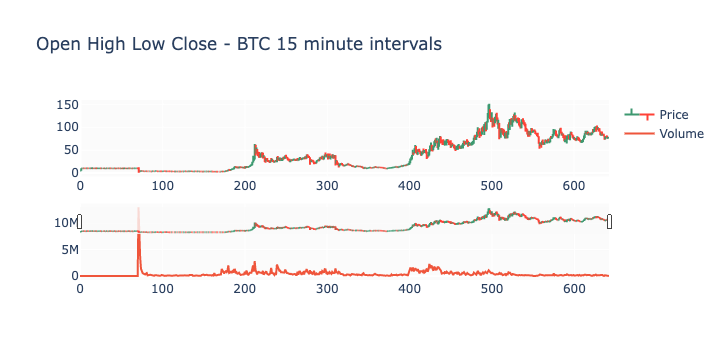

In [5]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=btc_df.index,
                      open=btc_df.open,
                      high=btc_df.high,
                      low=btc_df.low,
                      close=btc_df.close,
                      name='Price'), row=1, col=1)
fig.update_layout(
    title="Open High Low Close - BTC 15 minute intervals"
    )

fig.add_trace(go.Scatter(x=btc_df.index, y=btc_df.Volume, name='Volume'), row=2, col=1)
fig.update(layout_xaxis_rangeslider_visible=True)
fig.show()
fig.write_image(f'images/{img_name}ohlc.png')

In [6]:
df_close = btc_df[['time', 'close']].copy()
df_close = df_close.set_index('time')
df_close.head()

,close
time,
2020-07-13 00:00:00+00:00,4.895398
2020-07-14 00:00:00+00:00,10.297383
2020-07-15 00:00:00+00:00,10.392932
2020-07-16 00:00:00+00:00,10.358947
2020-07-17 00:00:00+00:00,10.363876


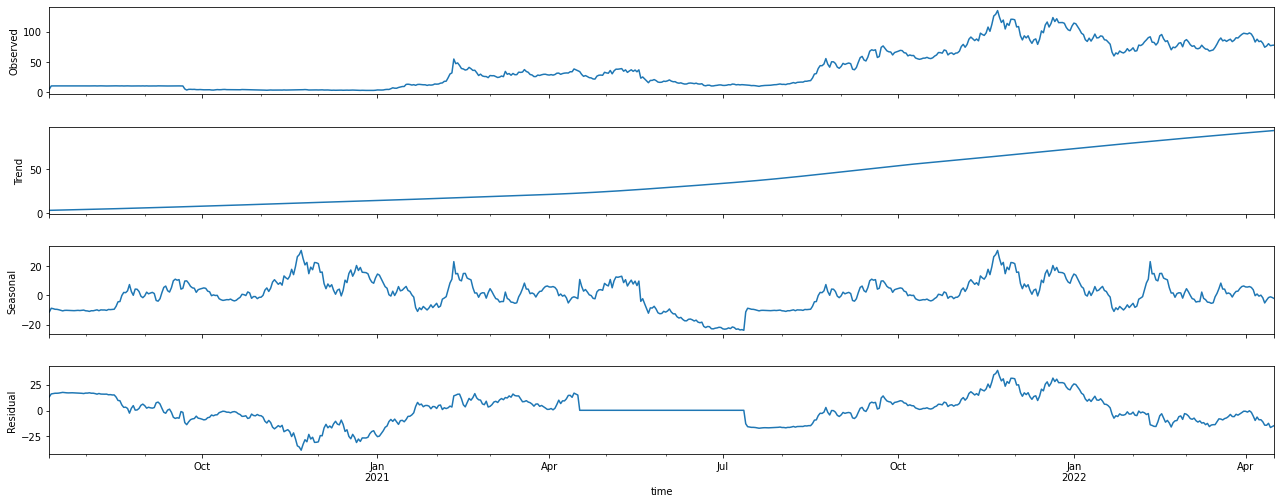

In [7]:
decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)
fig.savefig(f'images/{img_name}decomp.png')

### RSI to predict if the coin is overbought or over sold

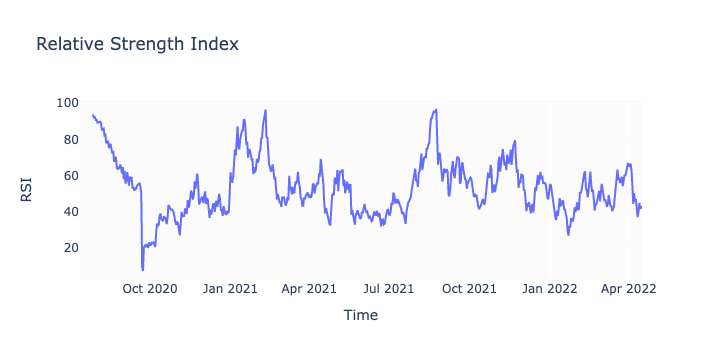

In [8]:
fig = go.Figure(go.Scatter(x=btc_df.time, y=btc_df.RSI, name='RSI'))
fig.update_layout(
    title='Relative Strength Index',
    xaxis_title='Time',
    yaxis_title='RSI'
    )
fig.show()
fig.write_image(f'images/{img_name}RSI.png')

### Indicators

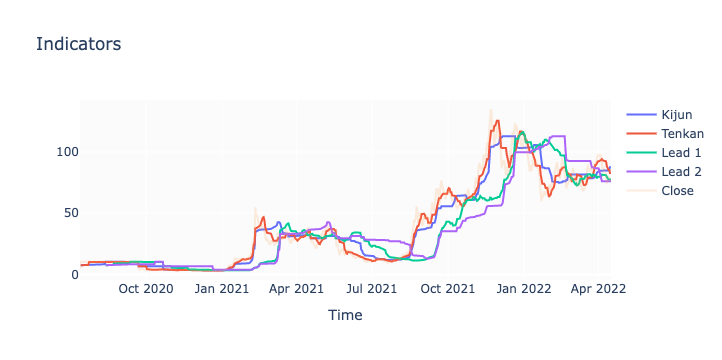

In [13]:
fig = go.Figure()
fig.update_layout(
    title='Indicators',
    xaxis_title='Time',
    )
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.Kijun, name='Kijun'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.Tenkan, name='Tenkan'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['Lead 1'], name='Lead 1'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['Lead 2'], name='Lead 2'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['close'], name='Close', opacity=0.2))
fig.show()
fig.write_image(f'images/{img_name}RSI.png')

Split stock data frame into two subsets: training ($70\%$)and test ($30\%$) sets. Calculated split indices and create separate dataframes (train_df, test_df). Frames have been ploted in the chart below.

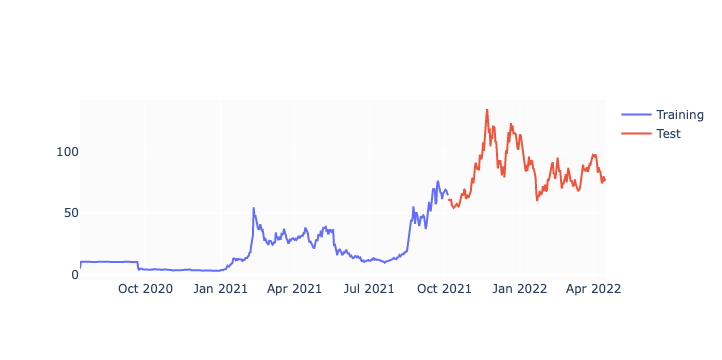

In [14]:
test_size  = 0.30
test_split_idx  = int(btc_df.shape[0] * (1-test_size))

train_df  = btc_df.loc[:test_split_idx - 1].copy()
test_df   = btc_df.loc[test_split_idx:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.time, y=train_df.close, name='Training'))
fig.add_trace(go.Scatter(x=test_df.time,  y=test_df.close,  name='Test'))
fig.show()
fig.write_image(f'images/{img_name}traintest.png')

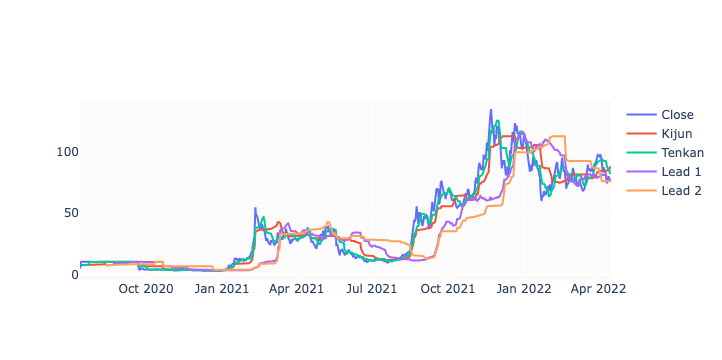

In [16]:
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['Kijun'], name='Kijun'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['Tenkan'], name='Tenkan'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['Lead 1'], name='Lead 1'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['Lead 2'], name='Lead 2'), row=1, col=1)
fig.show()
fig.write_image(f'images/{img_name}ichimoku.png')

### Drop Unnessary Columns

In [17]:
# This code needs to be optimized, they are manually changed depending on the desired idicators 
drop_cols = ['time', 'open', 'low', 'high', 'Plot','Up Trend', 
             'Down Trend', 'VWAP', 'Upper Band', 'Lower Band', 
             'Basis', 'Upper', 'Lower', 'Smoothing Line', 'CCI',
             'Lower Bollinger Band', 'Histogram', 
             'Smoothing Line.1', 'ADX', '+DI', '-DI', 'CHOP', 
             'Lagging Span', 'Volume', 'Volume MA', 'Upper Bollinger Band',
            'Signal', 'RSI-based MA', 'EMA', 'MACD', 'RSI']

train_df = train_df.drop(drop_cols, axis=1).dropna()
test_df = test_df.drop(drop_cols, axis=1).dropna()

In [18]:
train_df.head()

,close,Lead 1,Lead 2,Tenkan,Kijun
31,10.287351,7.637813,7.637813,10.273084,10.501988
32,10.368185,7.669992,7.669992,10.273084,10.501988
33,10.244732,7.686002,7.686002,10.273084,10.501988
34,10.438594,7.686002,7.686002,10.273084,10.501988
35,10.442608,7.686002,7.686002,10.273084,10.501988


### Split into features and labels

In [19]:
y_train = train_df['close'].copy()
X_train = train_df.drop(columns = ['close'])

y_test = test_df['close'].copy()
X_test = test_df.drop(columns = ['close'])


### Fine Tune XGRegressor

In [20]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42],  
}

model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0)

print(train_df.info())
print(test_df.info())
print(model)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 419 entries, 31 to 449
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   419 non-null    float64
 1   Lead 1  419 non-null    float64
 2   Lead 2  419 non-null    float64
 3   Tenkan  419 non-null    float64
 4   Kijun   419 non-null    float64
dtypes: float64(5)
memory usage: 19.6 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 450 to 641
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   192 non-null    float64
 1   Lead 1  192 non-null    float64
 2   Lead 2  192 non-null    float64
 3   Tenkan  192 non-null    float64
 4   Kijun   192 non-null    float64
dtypes: float64(5)
memory usage: 9.0 KB
None
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=No

In [21]:
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42}


In [22]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, verbose=False)

CPU times: user 2.44 s, sys: 747 ms, total: 3.18 s
Wall time: 1.09 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.02, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

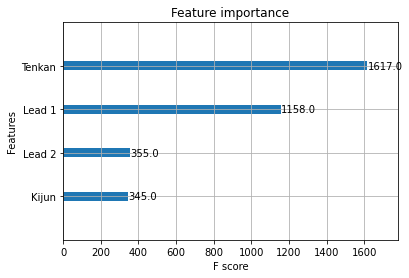

In [23]:
importance = plot_importance(model)
importance.figure.savefig(f'images/{img_name}importance.png')


### Calculate and Visualize Predictions

In [24]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [60.02739562 61.51859619 60.48661813 60.64506076 56.51833777]
y_pred = [57.14074 57.14074 57.14074 57.14074 57.14074]


In [25]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 1114.8214008504754


In [26]:
predicted_prices = btc_df.loc[test_split_idx:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.close,
                         name='Actual',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=y_test,
                         name='Actual',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()
fig.write_image(f'images/{img_name}predictions.png')

ValueError: Length of values (192) does not match length of index (193)